<div align="center">
    <img src="https://netspresso-docs-imgs.s3.ap-northeast-2.amazonaws.com/imgs/banner/NetsPresso2.0_banner.png"/>
</div>

# **NetsPresso Tutorial**

In this tutorial, we will guide you through the process of optimizing an AI model using NetsPresso.

The tutorial includes the following steps:

1. Training a YOLOX detection model using the Trainer.
2. Benchmarking the trained model using the Converter and Benchmarker.
3. Optimizing the trained model to meet a specified target latency with the Compressor.
4. Retraining the compressed model that meets the target latency using the Trainer.
5. Comparing the performance between the original model and the compressed model.

## 0. Login NetsPresso

To use the NetsPresso, please enter the email and password registered in [NetsPresso](https://www.netspresso.ai/).

In [1]:
from netspresso import NetsPresso

netspresso = NetsPresso(email="YOUR_EMAIL", password="YOUR_PASSWORD")

2024-02-02 10:39:31.099 | INFO     | netspresso.clients.config:<module>:11 - Read PROD config
2024-02-02 10:39:32.833 | INFO     | netspresso.clients.auth.main:login:38 - Login successfully
2024-02-02 10:39:33.526 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user information


## 1. Train the model(with **YOLOX**)
--------------------------------------------------

We will train an object detection model using YOLOX.

Following the training, we'll measure the latency on the **Raspberry Pi 4B**.


### 1-1. Download Dataset

The dataset was sourced from the provided [link](https://www.kaggle.com/code/valentynsichkar/traffic-signs-detection-by-yolo-v3-opencv-keras/input). 

We downloaded the Traffic Signs Dataset in YOLO format and utilized it for training.


In [2]:
!wget https://netspresso-github.s3.ap-northeast-2.amazonaws.com/traffic-sign.zip
!unzip traffic-sign.zip

--2024-02-02 10:39:33--  https://netspresso-github.s3.ap-northeast-2.amazonaws.com/traffic-sign.zip
Resolving netspresso-github.s3.ap-northeast-2.amazonaws.com (netspresso-github.s3.ap-northeast-2.amazonaws.com)... 52.219.206.14, 52.219.58.7, 52.219.146.50, ...
Connecting to netspresso-github.s3.ap-northeast-2.amazonaws.com (netspresso-github.s3.ap-northeast-2.amazonaws.com)|52.219.206.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261469534 (249M) [application/zip]
Saving to: ‘traffic-sign.zip’

traffic-sign.zip    100%[===================>] 249.36M  77.4MB/s    in 3.3s    

2024-02-02 10:39:37 (76.0 MB/s) - ‘traffic-sign.zip’ saved [261469534/261469534]

Archive:  traffic-sign.zip
   creating: traffic-sign/
   creating: traffic-sign/images/
   creating: traffic-sign/images/train/
  inflating: traffic-sign/images/train/00000.jpg  
  inflating: traffic-sign/images/train/00001.jpg  
  inflating: traffic-sign/images/train/00003.jpg  
  inflating: traffic-sig

### 1-2. Declare trainer

First, declare the Trainer. 

Currently, Trainer supports training pipelines about three computer vision tasks:

- IMAGE_CLASSIFICATION
- OBJECT_DETECTION
- SEMANTIC_SEGMENTATION

In [3]:
from netspresso.enums import Task

trainer = netspresso.trainer(task=Task.OBJECT_DETECTION)

### 1-3. Set dataset config

Please set the dataset you want to train.

In [4]:
trainer.set_dataset_config(
    name="traffic_sign_config_example",
    root_path="./traffic-sign",
    train_image="images/train",
    train_label="labels/train",
    valid_image="images/valid",
    valid_label="labels/valid",
    id_mapping=["prohibitory", "danger", "mandatory", "other"],
)

### 1-4. Set model config

Please set the model you want to train.

You can check the available models from `trainer.available_models`.

In [5]:
trainer.available_models

['EfficientFormer',
 'YOLOX-S',
 'ResNet',
 'MobileNetV3',
 'MixNetL',
 'MixNetM',
 'MixNetS']

We configured it as follows to train using the YOLOX model.

In [6]:
trainer.set_model_config(model_name="YOLOX-S", img_size=512)

### 1-5. Set augmentation config

Please set the augmentation.

In [7]:
from netspresso.trainer.augmentations import Resize

trainer.set_augmentation_config(
    train_transforms=[Resize()],
    inference_transforms=[Resize()],
)

### 1-6. Set training config

Please set the hyperparameter such as **epochs**, **batch size**, **optimizer**, and **scheduler** for training.

If training config is not set, it will be set as **the default option for the task**.

In [9]:
from netspresso.trainer.optimizers import AdamW
from netspresso.trainer.schedulers import CosineAnnealingWarmRestartsWithCustomWarmUp

trainer.set_training_config(
    epochs=40,
    batch_size=16,
    optimizer=AdamW(lr=6e-3),
    scheduler=CosineAnnealingWarmRestartsWithCustomWarmUp(warmup_epochs=10),
)

### 1-7. Train

Please assign a GPU to use for training.

- For single-gpu: "0"
- For multi-gpu: "0,1,2,3"

In [10]:
project_name = "training_sample"
training_result = trainer.train(gpus="0,1", project_name=project_name)

/opt/conda/lib/python3.10/site-packages/torch/distributed/launch.py:180: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
2024-02-02 10:40:02.976 | INFO     | netspresso_trainer.trainer_common:train_common:35 - Task: detection | Model: yolox_s | Training with torch.fx model? False
2024-02-02 10:40:02.977 | INFO     | netspresso_trainer.trainer_common:trai

## 2. Benchmark the trained model on **Raspberry Pi 4B**
-------------------------------------------------------

We will benchmark the trained model on **Raspberry Pi 4B**.

### 2-1. Convert the trained model

For benchmark on **Raspberry Pi 4B**, convert onnx using **TensorFlow-Lite**.

In [11]:
from netspresso.enums import Framework, DeviceName

converter = netspresso.converter()

original_conversion_result = converter.convert_model(
    input_model_path=training_result["best_onnx_model_path"],
    output_dir=f"./outputs/{project_name}/converted/original_model_tflite",
    target_framework=Framework.TENSORFLOW_LITE,
    target_device_name=DeviceName.RASPBERRY_PI_4B,
)

2024-02-02 10:46:15.446 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user information
2024-02-02 10:46:18.161 | INFO     | netspresso.converter.converter:convert_model:164 - Converting Model for RaspberryPi4B (tensorflow_lite)
2024-02-02 10:48:20.555 | INFO     | netspresso.converter.converter:_download_converted_model:60 - Model downloaded at outputs/training_sample/converted/original_model_tflite/original_model_tflite.tflite
2024-02-02 10:48:22.596 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user information
2024-02-02 10:48:22.599 | INFO     | netspresso.converter.converter:convert_model:223 - 50 credits have been consumed. Remaining Credit: 8875


### 2-2. Benchmark the trained model

Run benchmark on **Raspberry Pi 4B**.

In [12]:
benchmarker = netspresso.benchmarker()

original_benchmark_result = benchmarker.benchmark_model(
    input_model_path=original_conversion_result["converted_model_path"],
    target_device_name=DeviceName.RASPBERRY_PI_4B,
)
print(f"Model inference latency: {original_benchmark_result['result']['latency']} ms")

2024-02-02 10:48:23.215 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user information
2024-02-02 10:49:19.315 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user information
2024-02-02 10:49:19.318 | INFO     | netspresso.benchmarker.benchmarker:benchmark_model:171 - 25 credits have been consumed. Remaining Credit: 8850


Model inference latency: 927.104 ms


## 3. Optimize the trained model using Compressor
-------------------------------------------------

We aim to achieve a latency of less than **100 ms** on the **Raspberry Pi 4B** using a trained model. 

To meet this target, we will employ Compressor to create a model optimized for low latency."


### 3-1. Run automatic compression

After uploading the trained model, we will proceed with compression using automatic compression.

The compression ratio is set [0.3, 0.5, 0.7].

In [13]:
ratios = [0.3, 0.5, 0.7]

compressed_models = {}
for ratio in ratios:
    compressor = netspresso.compressor()
    compressed_model = compressor.automatic_compression(
        input_model_path=training_result["best_fx_model_path"],
        output_dir=f"./outputs/{project_name}/compressed/pruning_{ratio}",
        input_shapes=training_result["model_info"]["input_shapes"],
        compression_ratio=ratio,
    )
    compressed_models[ratio] = compressed_model

2024-02-02 10:49:19.330 | INFO     | netspresso.compressor.compressor:automatic_compression:683 - Compressing automatic-based model...
2024-02-02 10:49:19.899 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user information
2024-02-02 10:49:19.903 | INFO     | netspresso.compressor.compressor:upload_model:66 - Uploading Model...
2024-02-02 10:49:33.309 | INFO     | netspresso.compressor.compressor:upload_model:78 - Upload model successfully. Model ID: 71c712b4-4ad8-451f-aa83-bb8c7c0fac60
2024-02-02 10:49:33.311 | INFO     | netspresso.compressor.compressor:automatic_compression:715 - Compressing model...
2024-02-02 10:49:54.272 | INFO     | netspresso.compressor.compressor:get_compression:261 - Getting compression...
2024-02-02 10:49:54.745 | INFO     | netspresso.compressor.compressor:get_compression:273 - Get compression successfully.
2024-02-02 10:49:54.747 | INFO     | netspresso.compressor.compressor:download_model:135 - Downloading model...
2024-02-0

### 3-2. Convert the compressed models

For benchmark on **Raspberry Pi 4B**, convert onnx using **TensorFlow-Lite**.

In [14]:
converter = netspresso.converter()
conversion_results = {}

for ratio in ratios:
    conversion_result = converter.convert_model(
        input_model_path=compressed_models[ratio]['compressed_onnx_model_path'],
        output_dir=f"./outputs/{project_name}/converted/pruning_{ratio}",
        target_framework=Framework.TENSORFLOW_LITE,
        target_device_name=DeviceName.RASPBERRY_PI_4B,
    )
    conversion_results[ratio] = conversion_result

2024-02-02 10:51:19.268 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user information
2024-02-02 10:51:21.040 | INFO     | netspresso.converter.converter:convert_model:164 - Converting Model for RaspberryPi4B (tensorflow_lite)
2024-02-02 10:52:37.043 | INFO     | netspresso.converter.converter:_download_converted_model:60 - Model downloaded at outputs/training_sample/converted/pruning_0.3/pruning_0.3.tflite
2024-02-02 10:52:38.921 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user information
2024-02-02 10:52:38.925 | INFO     | netspresso.converter.converter:convert_model:223 - 50 credits have been consumed. Remaining Credit: 8725
2024-02-02 10:52:39.503 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user information
2024-02-02 10:52:41.161 | INFO     | netspresso.converter.converter:convert_model:164 - Converting Model for RaspberryPi4B (tensorflow_lite)
2024-02-02 10:53:36.005 | INFO     

### 3-3. Benchmark the compressed models

Run benchmark on **Raspberry Pi 4B**.

In [15]:
benchmarker = netspresso.benchmarker()
benchmark_results = {}
for ratio in ratios:
    benchmark_result = benchmarker.benchmark_model(
        input_model_path=conversion_results[ratio]["converted_model_path"],
        target_device_name=DeviceName.RASPBERRY_PI_4B,
    )
    benchmark_results[ratio] = benchmark_result

2024-02-02 10:54:27.200 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user information
2024-02-02 10:55:05.020 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user information
2024-02-02 10:55:05.024 | INFO     | netspresso.benchmarker.benchmarker:benchmark_model:171 - 25 credits have been consumed. Remaining Credit: 8600
2024-02-02 10:55:05.578 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user information
2024-02-02 10:55:33.670 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user information
2024-02-02 10:55:33.674 | INFO     | netspresso.benchmarker.benchmarker:benchmark_model:171 - 25 credits have been consumed. Remaining Credit: 8575
2024-02-02 10:55:34.207 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user information
2024-02-02 10:55:52.796 | INFO     | netspresso.clients.auth.main:get_user_info:55 - Successfully got user in

### 3-4. Comparison of latency and FLOPs corresponding to the compression ratios

Let's analyze how **latency** and **FLOPs** vary with different compression ratios.

In [16]:
from netspresso.utils.plotter import Plotter

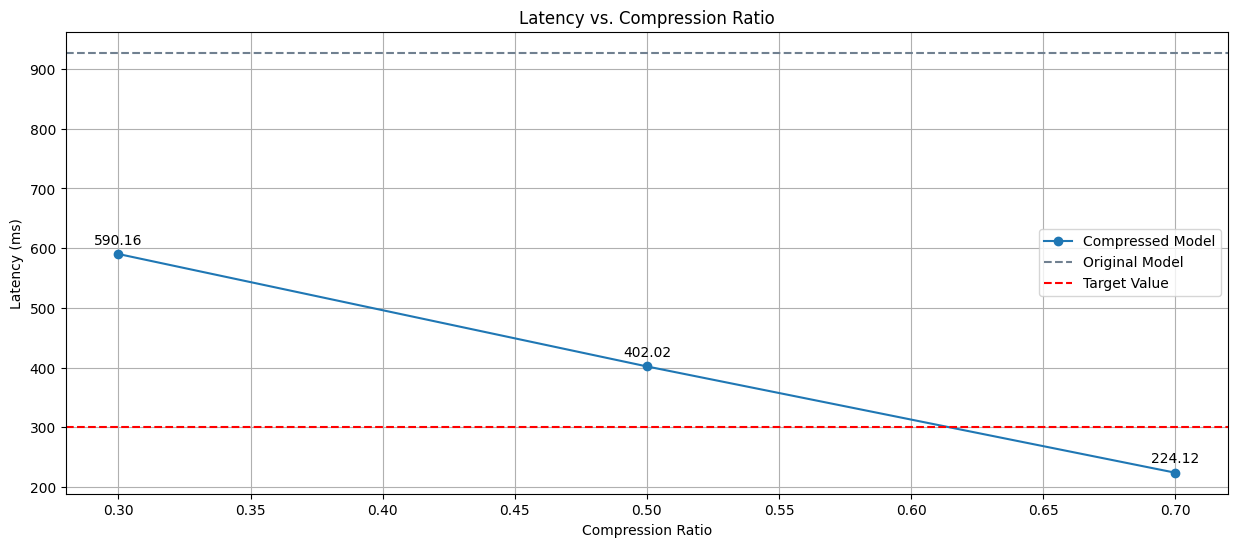

In [17]:
original_latency = original_benchmark_result['result']['latency']
compressed_latency = {ratio : benchmark_results[ratio]['result']['latency'] for ratio in ratios}
Plotter.compare_latency(original_latency=original_latency, latency_per_model=compressed_latency, target_latency=300)

The compression ratio of **0.7** meet our target latency of 300 ms.

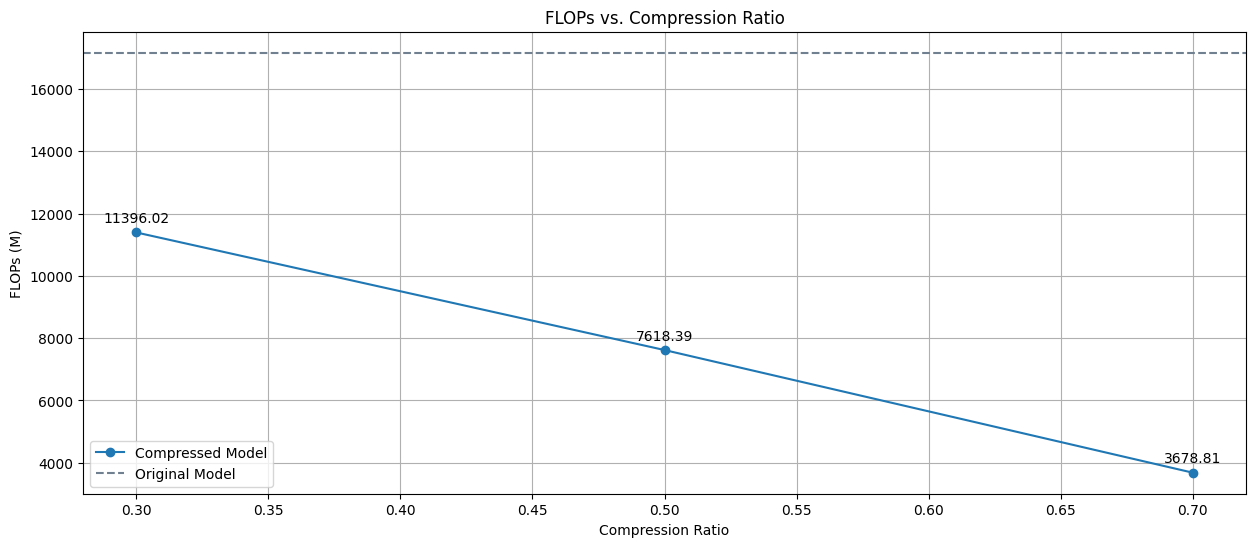

In [18]:
original_flops = compressed_models[0.3]['results']['original_model']['flops']
compressed_flops = {ratio : compressed_models[ratio]['results']['compressed_model']['flops'] for ratio in ratios}
Plotter.compare_flops(original_flops=original_flops, flops_per_model=compressed_flops)

## 4. Retrain the compressed model

Then, we will retrain the compressed model with **ratio=0.7** and check the performance.

### 4-1. Train the compressed model

In [19]:
selected_pruning_ratio = 0.7

hparams_yaml = training_result["hparams"]
compressed_model_path = compressed_models[selected_pruning_ratio]["compressed_model_path"]

# 1. Declare Retrainer
trainer = netspresso.trainer(yaml_path=hparams_yaml)

trainer.set_fx_model(fx_model_path=compressed_model_path)

optimizer = AdamW(lr=6e-3)
scheduler = CosineAnnealingWarmRestartsWithCustomWarmUp(warmup_epochs=10)
trainer.set_training_config(
    epochs=30,
    batch_size=16,
    optimizer=optimizer,
    scheduler=scheduler,
)

project_name = "retraining_sample"
retraining_result = trainer.train(gpus="0,1", project_name=project_name)

/opt/conda/lib/python3.10/site-packages/torch/distributed/launch.py:180: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
2024-02-02 10:55:57.445 | INFO     | netspresso_trainer.trainer_common:train_common:35 - Task: detection | Model: yolox_s_graphmodule | Training with torch.fx model? True
2024-02-02 10:55:57.445 | INFO     | netspresso_trainer.trainer_

## 5. Comparison of performance metric between original model and compressed model

The comparison between the original model and the compressed model is depicted in the plot, illustrating their performance across different metrics. 

Each subplot corresponds to a specific metric (**mAP50**, **mAP75**, **mAP50_95**).

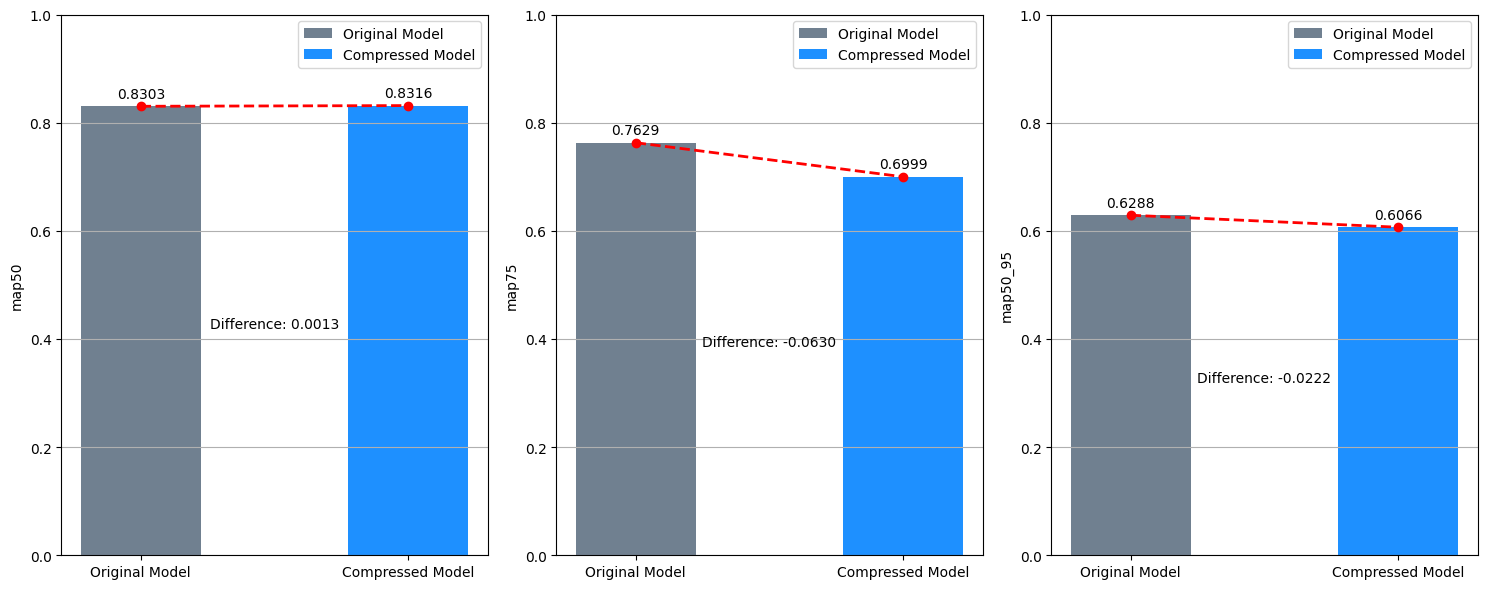

In [20]:
Plotter.compare_metric(training_result, retraining_result)

For each metric:

- Original Model Bar: Represented by a gray bar labeled "Original Model", representing the performance metric value of the original model.

- Compressed Model Bar: Represented by a blue bar labeled "Compressed Model", representing the performance metric value of the compressed model.

- Difference Text: The difference value between the original and compressed models for each metric.ic."

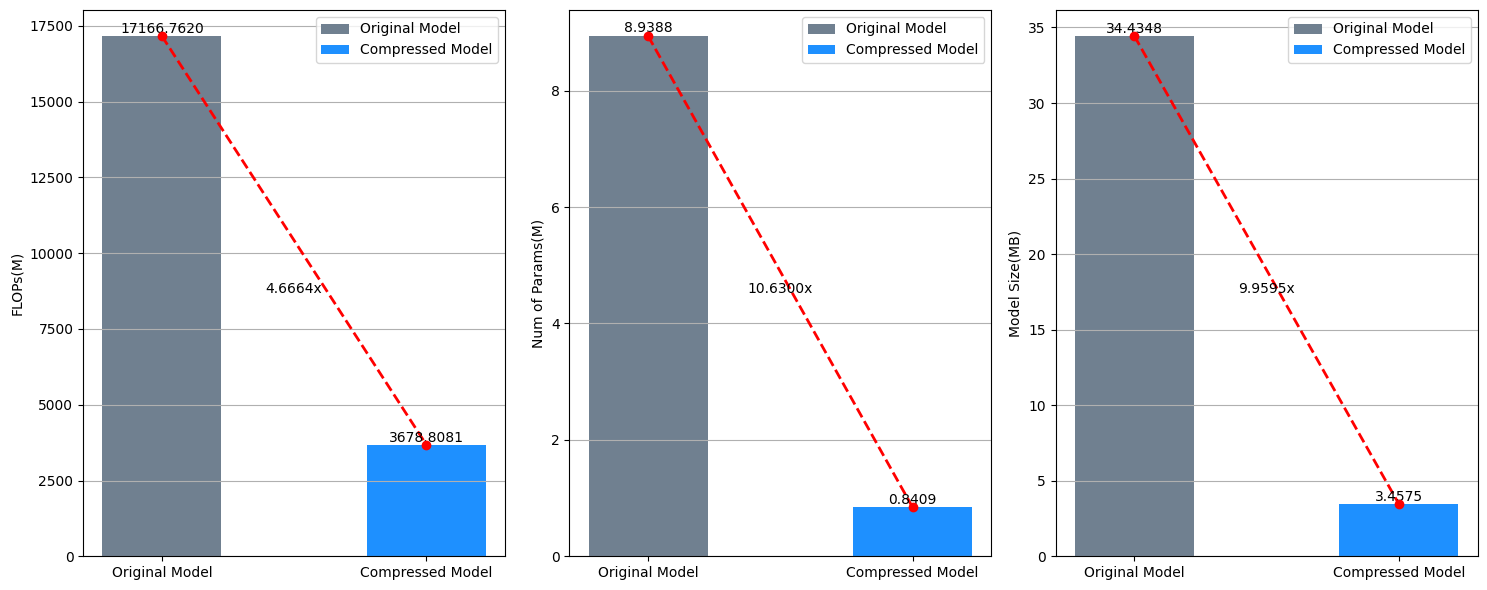

In [21]:
Plotter.compare_profile_result(compressed_models[selected_pruning_ratio])